In [ ]:
import torch, torchvision
from torch import nn
from torch import optim
import torchvision.transforms as TT
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from PIL import Image

In [ ]:
T = torchvision.transforms.Compose([
    TT.ToTensor(), TT.Normalize((0.5,),(0.5,))
])
no_of_batch = 64
train_data = torchvision.datasets.MNIST('mnist_data', train=True, download=True, transform=T)
val_data = torchvision.datasets.MNIST('mnist_data', train=False, download=True, transform=T)
train_dl = torch.utils.data.DataLoader(train_data, batch_size = no_of_batch)
val_dl = torch.utils.data.DataLoader(val_data, batch_size = no_of_batch)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



In [ ]:
print(type(train_data[0][0]))

<class 'torch.Tensor'>


In [ ]:
len(train_data)

60000

In [ ]:
len(val_data)

10000

In [ ]:
# for i in range(10):
#  t = train_data[i][0]    # t is object containing both image and its label
#  img = np.array(t)
#  im = plt.imshow(img)
#  plt.show()

In [ ]:
# Creating a model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class Net(nn.Module):
    """order of build model:- ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
n_epochs = 4
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
# momentum = 0.5
log_interval = 10

In [ ]:
model = Net().to(device)
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

In [ ]:
print(model)

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)


In [ ]:
# Model Summary
from torchsummary import summary
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                   [-1, 10]           5,010
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 1.64
Estimated Total Size (MB): 1.76
----------------------------------------------------------------


In [ ]:
train_losses = []
train_counter = []
val_loss1 = []
val_losses = []
val_counter = []

In [ ]:
def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(train_dl):
    data = data.cuda()
    target = target.cuda()
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_dl.dataset),
        100. * batch_idx / len(train_dl), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_dl.dataset)))

In [ ]:
def val_loss(epoch):
    model.eval()
    for batch_idx, (data, target) in enumerate(val_dl):
      data = data.cuda()
      target = target.cuda()
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      if batch_idx % log_interval == 0:
        print('Val Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(val_dl.dataset),
          100. * batch_idx / len(val_dl), loss.item()))
        val_loss1.append(loss.item())
        val_counter.append((batch_idx*64) + ((epoch-1)*len(val_dl.dataset)))

In [ ]:
def val_accu():
  model.eval()
  val_loss = 0
  correct = 0
  with torch.no_grad():
    for data,target in val_dl:
      data = data.cuda()
      target = target.cuda()
      output = model(data)
      val_loss += criterion(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  val_loss /= len(val_dl.dataset)
  val_losses.append(val_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    val_loss, correct, len(val_dl.dataset),
    100. * correct / len(val_dl.dataset)))

In [ ]:
for epoch in range(1, n_epochs + 1):
  train(epoch)
  val_loss(epoch)
  val_accu()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308296
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.900285
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.606532
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.408427
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.319073
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.276709
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.101399
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.173440
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.126650
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.103671
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.126595
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.296822
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.129858
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.095352
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.150306
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.161335
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.395488
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.226061
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.229776
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.182573
Train Epoch: 1 [12800/60000 (

Text(0, 0.5, 'Cross Entropy loss')

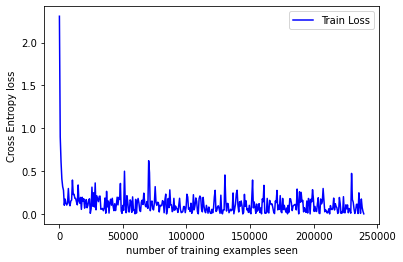

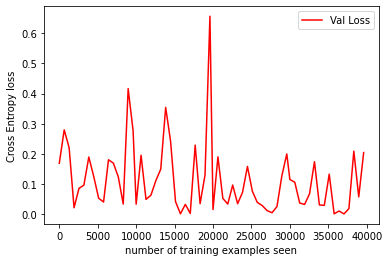

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.legend(['Train Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Cross Entropy loss')

fig = plt.figure()
plt.plot(val_counter, val_loss1, color='red')
plt.legend(['Val Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('Cross Entropy loss')

In [ ]:
def predict_dl(model, data):
    y_pred = []
    y_true = []
    for i, (images, labels) in enumerate(data):
        images = images.cuda()
        x = model(images)
        value, pred = torch.max(x, 1)
        pred = pred.data.cpu()
        y_pred.extend(list(pred.numpy()))
        y_true.extend(list(labels.numpy()))
    return np.array(y_pred), np.array(y_true)

In [ ]:
y_pred, y_true = predict_dl(model,val_dl)

In [ ]:
pd.DataFrame(confusion_matrix(y_true, y_pred, labels=np.arange(0,10)))

,0,1,2,3,4,5,6,7,8,9
0,980,0,0,0,0,0,0,0,0,0
1,0,1130,2,1,0,0,0,2,0,0
2,6,2,1013,4,0,0,4,3,0,0
3,0,0,3,1005,0,1,0,1,0,0
4,1,0,0,0,976,0,1,0,0,4
5,3,0,0,13,0,875,0,0,0,1
6,13,3,0,0,3,1,936,0,2,0
7,3,3,4,2,2,1,0,1003,1,9
8,12,3,10,4,2,4,0,4,922,13
9,11,2,0,3,10,0,0,1,0,982
